In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
from src import FlairDataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
path = "../data/external/real_fake_disaster/"

## Load the dataset

1. Give the path for the data
2. Give the filename of the data
3. Label the column names for (text,target)

In [4]:
dataset = FlairDataset.csv_classification(data_folder=path,filename='data',column_mapping=['text','label'])

2020-04-03 00:59:59,117 entiretydotai DEBUG Found directory : /home/uv/Documents/meetup(in_progress)/entiretydotai/data/external/real_fake_disaster
2020-04-03 00:59:59,119 entiretydotai DEBUG Number of files found 1
2020-04-03 00:59:59,119 entiretydotai DEBUG Found 1 file : data.csv
2020-04-03 00:59:59,120 entiretydotai DEBUG Setting train_val_test_split_flag to True
2020-04-03 00:59:59,123 entiretydotai DEBUG [sel_column_label] : Ran with args: (PosixPath('/home/uv/Documents/meetup(in_progress)/entiretydotai/data/external/real_fake_disaster/data.csv'), ['text', 'label'], ['text', 'label']), and kwargs: {}
2020-04-03 00:59:59,154 entiretydotai DEBUG [sel_column_label] ran in: 0.02989959716796875 sec
2020-04-03 00:59:59,155 entiretydotai DEBUG [column_name_map] {3: 'text', 4: 'label'}
2020-04-03 00:59:59,182 entiretydotai DEBUG NUmber of rows in the dataset: 7613
2020-04-03 00:59:59,183 entiretydotai DEBUG Index(['id', 'keyword', 'location', 'text', 'label'], dtype='object')
2020-04-03 

In [5]:
dataset.column_name_map

{3: 'text', 4: 'label'}

### Dataset is split using Stratified Sampling.Hence the class distribution will similar in train,valid,test dataset

In [6]:
dataset.valid_data.label.value_counts()/len(dataset.valid_data)

0    0.569971
1    0.430029
Name: label, dtype: float64

In [7]:
dataset.test_data.label.value_counts()/len(dataset.test_data)

0    0.570866
1    0.429134
Name: label, dtype: float64

### Load the word Embeddings

1. Avaliable options
    [Flair Embeddings](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_4_ELMO_BERT_FLAIR_EMBEDDING.md)

In [8]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings,DocumentRNNEmbeddings
from flair.models import TextClassifier

In [9]:
word_embeddings = [WordEmbeddings('glove')]

In [10]:
DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                             hidden_size=512,
                                                             reproject_words=True,
                                                             reproject_words_dimension=256)

In [11]:
classifier = TextClassifier(DocumentRNNEmbeddings, label_dictionary=dataset.corpus.make_label_dictionary(),multi_label=False)

2020-04-03 01:00:00,677 Computing label dictionary. Progress:


100%|██████████| 6166/6166 [00:02<00:00, 2091.21it/s]

2020-04-03 01:00:03,758 [b'label', b'0', b'1']


In [12]:
classifier

TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
    )
    (word_reprojection_map): Linear(in_features=100, out_features=256, bias=True)
    (rnn): GRU(256, 512, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=512, out_features=3, bias=True)
  (loss_function): CrossEntropyLoss()
)

In [13]:
from flair.trainers import ModelTrainer
# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, dataset.corpus)

2020-04-03 01:00:03,945 ----------------------------------------------------------------------------------------------------
2020-04-03 01:00:03,949 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
    )
    (word_reprojection_map): Linear(in_features=100, out_features=256, bias=True)
    (rnn): GRU(256, 512, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=512, out_features=3, bias=True)
  (loss_function): CrossEntropyLoss()
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-04-03 01:00:03,952 ----------------------------------------------------------------------------------------------------
2020-04-03 01:00:03,960 Corpus: "Corpus: 6166 train + 687 dev + 763 test sentences"
2020-04-03 01:00:03,965 ----------------------------------------------------------------------------------------------------
2020-04-03 01:00:0

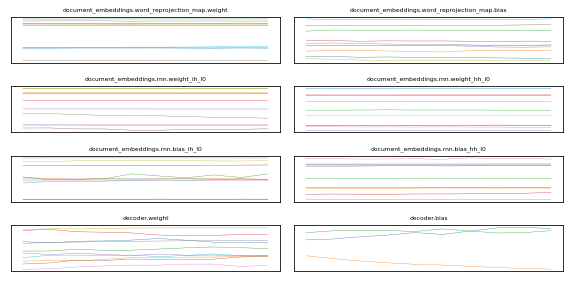

In [14]:
# 7. start the training
trainer.train('../models/real_fake',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=1)

# 8. plot weight traces (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('../models/real_fake/weights.txt')

In [15]:
dataset.valid_data

,id,keyword,location,text,label
6037,8628,seismic,412 NW 5th Ave. Portland OR,Still no plans? Don't worry we got you covered...,0
1800,2587,crash,NaN,??One night and we're gonna come and crash the...,0
5401,7707,panicking,Oxford / bristol,Okay NOW I AM PANICKING,0
3171,4550,emergency%20plan,"Alexandria, VA, USA",See Aug 4 2015 PoconoRecord @EmergencyMgtMag -...,1
1162,1673,bridge%20collapse,NaN,Australia's Ashes disaster - how the collapse ...,1
...,...,...,...,...,...
4291,6096,hellfire,NaN,Beware of your temper and a loose tongue! Thes...,0
140,201,airplane%20accident,NaN,@AlexAllTimeLow awwww they're on an airplane a...,1
1118,1613,bombed,NaN,@r_lauren83199 @xojademarie124 i hope you get ...,0
2544,3650,destroy,"Virginia, USA",destroy the free fandom honestly,1


In [16]:
from flair.data import Sentence
classifier = TextClassifier.load('../models/real_fake/final-model.pt')

# create sentence from valid dataset
sentences = [Sentence(sent, use_tokenizer=True) for sent in dataset.valid_data.text.to_list()]

# predict class and print
sentences = classifier.predict(sentences)

2020-04-03 01:00:58,830 loading file ../models/real_fake/final-model.pt


In [17]:
predictions = [(int(str(i[0]).split(" ")[0])) for i in [sentences[i].labels for i in range(0,len(sentences))]]
predictions_prob = [float(str(i[0]).split(" ")[1].strip("(").strip(")")) for i in [sentences[i].labels for i in range(0,len(sentences))]]

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

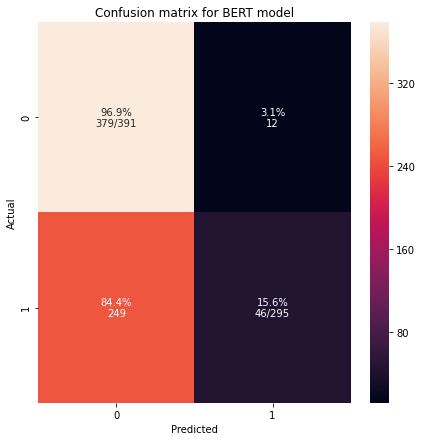

In [19]:
plot_cm(dataset.valid_data.label,predictions, 'Confusion matrix for BERT model', figsize=(7,7))